### Importing the required libraries

In [1]:
import pandas as pd
import datetime
import pandas_datareader as pdr
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
start = datetime.datetime(2014, 9, 20)
end = datetime.datetime(2021, 5, 20)

In [3]:
df = pdr.get_data_yahoo(['BTC-USD'], start=start, end=end)
df.tail()

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2021-05-16,43537.511719,43537.511719,46623.558594,42207.289062,46415.898438,7.490364e+10
2021-05-17,42909.402344,42909.402344,45812.457031,42367.832031,43488.058594,5.618737e+10
2021-05-18,37002.441406,37002.441406,43546.117188,30681.496094,42944.976562,1.263581e+11
2021-05-19,40782.738281,40782.738281,42462.984375,35050.617188,36753.667969,8.828194e+10
2021-05-20,37304.691406,37304.691406,42172.171875,33616.453125,40596.949219,8.205162e+10


In [4]:
df.reset_index(inplace=True)
df.columns = df.columns.droplevel(level=1)
df.drop(columns=['Date', 'Adj Close'], inplace=True, axis=1)
df.head(3)

Attributes,Close,High,Low,Open,Volume
0,408.903992,423.295990,389.882996,394.673004,36863600.0
1,398.821014,412.425995,393.181000,408.084991,26580100.0
2,402.152008,406.915985,397.130005,399.100006,24127600.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2432 non-null   float64
 1   High    2432 non-null   float64
 2   Low     2432 non-null   float64
 3   Open    2432 non-null   float64
 4   Volume  2432 non-null   float64
dtypes: float64(5)
memory usage: 95.1 KB


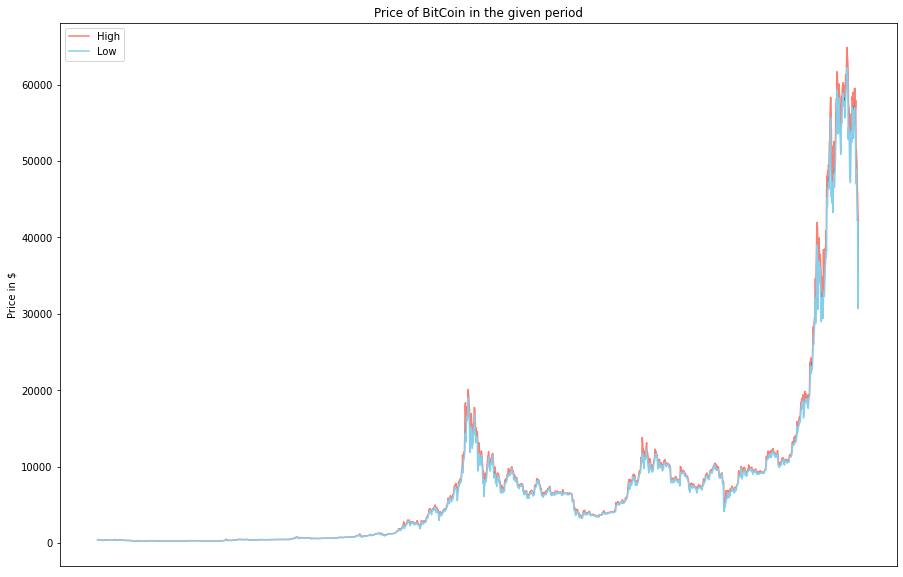

In [6]:
plt.figure(figsize=(15, 10))
plt.plot(df['High'], label='High', color='salmon')
plt.plot(df['Low'], label='Low', color='skyblue')
plt.fill_between(y1=df['Low'], y2=df['High'], x=np.arange(df.shape[0]))
plt.xticks([])
plt.title('Price of BitCoin in the given period')
plt.ylabel('Price in $')
plt.legend()

In [7]:
num_test_data = 7
period = 24
n_data = df.shape[0]

In [8]:
df['index'] = np.arange(df.shape[0])
df.set_index('index', inplace=True)

### Splitting the train and test data

In [9]:
test_data_indices_targets = np.random.choice(np.arange(period, n_data), num_test_data)

In [10]:
test_data_indices = []
for index in test_data_indices_targets:
    test_data_indices.append([item for item in range(index-period, index+1)])
test_data_indices_agg = [item for sub_list in test_data_indices for item in sub_list]

In [11]:
train_data_indices_agg = [index for index in np.arange(n_data) if index not in test_data_indices_agg]

In [12]:
def are_all_days_included(index, train_data_indices_agg):
    for item in range(index-period, index+1):
        if item not in train_data_indices_agg:
            return False
    return True

In [13]:
train_data_indices = []
for index in train_data_indices_agg:
    if index >= period and are_all_days_included(index, train_data_indices_agg):
        train_data_indices.append([item for item in range(index-period, index+1)])

In [14]:
train_data_indices_agg = [item for sub_list in train_data_indices for item in sub_list]

In [15]:
len(train_data_indices), len(test_data_indices)

(2130, 7)

In [16]:
df_train = df.iloc[train_data_indices_agg].drop_duplicates()
df_test = df.iloc[test_data_indices_agg].drop_duplicates()

### Fitting the MinMaxScaler on the training Data

In [17]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(df_train)

MinMaxScaler()

In [18]:
df_train = pd.DataFrame(minMaxScaler.transform(df_train.values), columns=df_train.columns, index=df_train.index)
df_test = pd.DataFrame(minMaxScaler.transform(df_test.values), columns=df_test.columns, index=df_test.index)

In [19]:
# df_train = np.log(df_train)
# df_test = np.log(df_test)

In [20]:
df_train.head(3)

Attributes,Close,High,Low,Open,Volume
index,,,,,
0,0.003645,0.003272,0.003520,0.003438,0.000088
1,0.003485,0.003104,0.003573,0.003650,0.000059
2,0.003538,0.003019,0.003637,0.003508,0.000052


### Making the data ready

In [21]:
y = df_train.pop('Close')
X = df_train.copy()

_y = df_test.pop('Close')
_X = df_test.copy()

### Separating the dataset into periods of 24 days and making the X_dataset and y_dataset

In [22]:
X_train = np.zeros((len(train_data_indices), period, 4))
y_train = np.zeros((len(train_data_indices)))
for index, batch in enumerate(train_data_indices):
    X_train[index] = X.loc[batch[:-1]].values.reshape(period, 4)
    y_train[index] = y.loc[batch[-1]]

In [23]:
X_test = np.zeros((len(test_data_indices), period, 4))
y_test = np.zeros((len(test_data_indices)))
for index, batch in enumerate(test_data_indices):
    X_test[index] = _X.loc[batch[:-1]].values.reshape(period, 4)
    y_test[index] = _y.loc[batch[-1]]

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2130, 24, 4), (2130,), (7, 24, 4), (7,))

### Creating the Data Loaders

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import re
from termcolor import colored
from tqdm.notebook import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=False, stratify=None)

In [27]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1917, 24, 4), (213, 24, 4), (1917,), (213,))

In [28]:
batch_size = 64

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

X_val = torch.tensor(X_val)
y_val = torch.tensor(y_val)

X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

train_data = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=batch_size)

val_data = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

test_data = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [29]:
for data, target in train_dataloader:
    print('the shape of the train data tensor: {}'.format(data.shape))
    print('the shape of the train target tensor: {}'.format(target.shape))
    break

the shape of the train data tensor: torch.Size([64, 24, 4])
the shape of the train target tensor: torch.Size([64])


### Utility Functions

In [30]:
def plot_train_test_metric(train_acc, val_acc, xlabel, ylabel, title, metric, ax):
    ax.plot(train_acc, color='salmon', label='train {}'.format(metric), marker='o', linewidth=1)
    ax.annotate(str(np.round(train_acc[-1], 5)), (len(train_acc) - .8, train_acc[-1]), color='salmon')
    ax.plot(val_acc, color='skyblue', label='val {}'.format(metric), marker='o', linewidth=1)
    ax.annotate(str(np.round(val_acc[-1], 5)), (len(val_acc) - .8, val_acc[-1]), color='skyblue')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis='y')

In [31]:
def inverse_the_outputs(outputs, minMaxScaler):
#     outputs = np.exp(outputs)
    outputs = np.array(outputs.tolist())
    temp = pd.DataFrame({
    'Close': outputs, 
    'High': np.zeros_like(outputs), 
    'Low': np.zeros_like(outputs), 
    'Open': np.zeros_like(outputs), 
    'Volume': np.zeros_like(outputs) 
    })
    outputs = pd.DataFrame(minMaxScaler.inverse_transform(temp.values), columns=temp.columns).Close.values
    return outputs

In [32]:
def plot_actual_vs_predicted(predicted, actuals, ax, title):
    ax.plot(predicted, label='predicted', c='salmon', marker='o', linewidth=1)
    ax.plot(actuals, label='actual', c='skyblue', marker='o', linewidth=1)
    ax.grid(axis='x')
    ax.set_title('Difference betweent the actual price of bitcoin - {}'.format(title))
    ax.legend()

### Model Specification (LSTM)

In [33]:
class Lstm_model(nn.Module):
    
    def __init__(self, n_features, hidden_dim, n_output, dropout_rate):
        super(Lstm_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_dim[0], batch_first=True)
        self.fc1 = nn.Linear(hidden_dim[0], hidden_dim[1])
        if dropout_rate != None:
            self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim[1], n_output)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x[:, -1, :])
        x = nn.ReLU()(x)
        if self.dropout_rate != None: 
            x = self.dropout(x)
        x = torch.squeeze(self.fc2(x), 1)
        return x

In [34]:
lstm_model = Lstm_model(4, [100, 50], 1, None)
output = lstm_model(torch.rand((64, 24, 4)))

### Model Specification (GRU)

In [35]:
class Gru_model(nn.Module):
    
    def __init__(self, n_features, hidden_dim, n_output, dropout_rate):
        super(Gru_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.gru = nn.GRU(input_size=n_features, hidden_size=hidden_dim[0], batch_first=True)
        self.fc1 = nn.Linear(hidden_dim[0], hidden_dim[1])
        if dropout_rate != None:
            self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim[1], n_output)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc1(x[:, -1, :])
        x = nn.ReLU()(x)
        if self.dropout_rate != None: 
            x = self.dropout(x)
        x = torch.squeeze(self.fc2(x), 1)
        return x

### Model Specification (RNN)

In [36]:
class RNN_model(nn.Module):
    
    def __init__(self, n_features, hidden_dim, n_output, dropout_rate):
        super(RNN_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim[0], batch_first=True)
        self.fc1 = nn.Linear(hidden_dim[0], hidden_dim[1])
        if dropout_rate != None:
            self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim[1], n_output)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc1(x[:, -1, :])
        x = nn.ReLU()(x)
        if self.dropout_rate != None:
            x = self.dropout(x)
        x = torch.squeeze(self.fc2(x), 1)
        return x

In [37]:
def initialize_model(model_name, n_features, hidden_dim, n_output, epochs, optimizer_name, dropout_rate):
    if model_name == 'lstm':
        model = Lstm_model(
            n_features=n_features, 
            hidden_dim=hidden_dim, 
            n_output=n_output,
            dropout_rate=dropout_rate
        )
    elif model_name == 'gru': 
        model = Gru_model(
            n_features=n_features, 
            hidden_dim=hidden_dim, 
            n_output=n_output,
            dropout_rate=dropout_rate
        )
    elif model_name == 'rnn': 
        model = RNN_model(
            n_features=n_features, 
            hidden_dim=hidden_dim, 
            n_output=n_output,
            dropout_rate=dropout_rate
        )
    elif model_name == 'mlp':
        model = MLP_model(
            n_features=n_features, 
            hidden_dim=hidden_dim, 
            n_output=n_output,
            dropout_rate=dropout_rate
        )
    elif model_name == 'gru_extended':
        model = Gru_extended_layers_model(
            n_features=n_features, 
            hidden_dim=hidden_dim, 
            n_output=n_output,
            dropout_rate=dropout_rate
        )    
    elif model_name == 'cnn_lstm':
        model = CNN_LSTM_model(
            n_features=n_features, 
            hidden_dim=hidden_dim, 
            n_output=n_output,
            dropout_rate=dropout_rate
        )

    # Create the optimizer
    if optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.001)
    elif optimizer_name== 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    elif optimizer_name == 'adagrad': 
        optimizer = optim.Adagrad(model.parameters(), lr=0.001)
    
    return model, optimizer

### Training and Evaluating the Model

In [38]:
import random
import time

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, optimizer, val_dataloader, epochs, evaluation):
    """Train the BertClassifier model.
    """

#     val_accuracy_list = []
#     train_accuracy_list = []
    val_loss_list = []
    train_loss_list = []

    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):

#         train_epoch_accuracy_list = []
        train_epoch_loss_list = []
        
#         print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Elapsed':^9}")
#         print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, (data, targets) in enumerate(train_dataloader):
            batch_counts +=1

            model.zero_grad()

            outputs = model(data.float())

            loss = loss_fn(outputs, targets.float())
            batch_loss += loss.item()
            total_loss += loss.item()

#             preds = torch.argmax(logits, dim=1).flatten()

#             accuracy = (preds == b_labels).cpu().numpy().mean() * 100
#             train_epoch_accuracy_list.append(accuracy)
            train_epoch_loss_list.append(loss.item())


            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
#             scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
#                 print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
#         train_accuracy_list.append(np.mean(train_epoch_accuracy_list))
        train_loss_list.append(np.mean(train_epoch_loss_list))

#         print("-"*70)

        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss = evaluate(model, val_dataloader)
#             val_accuracy_list.append(val_accuracy)
            val_loss_list.append(val_loss)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
#             print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {time_elapsed:^9.2f}")
#             print("-"*70)
#         print("\n")
    
    print("Training complete!")
    return train_loss_list, val_loss_list


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """

    model.eval()


    val_loss = []


    for data, targets in val_dataloader:



        with torch.no_grad():
            outputs = model(data.float())


        loss = loss_fn(outputs, targets.float())
        val_loss.append(loss.item())

    val_loss = np.mean(val_loss)


    return val_loss

In [39]:
import torch.nn.functional as F

def predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_outputs = []

    # For each batch in our test set...
    for data, targets in test_dataloader:

        # Compute logits
        with torch.no_grad():
            outputs = model(data.float())
        all_outputs.append(outputs)
    
    # Concatenate logits from each batch
    all_outputs = torch.cat(all_outputs, dim=0)

    return all_outputs

In [40]:
def test_model(model_name, epochs, hidden_dim, optimizer_name, dropout_rate):
#     loss_fn = loss_function
    set_seed(42)    # Set seed for reproducibility
    
    model, optimizer = initialize_model(
        model_name=model_name, 
        n_features = 4, 
        hidden_dim = hidden_dim, 
        n_output = 1,
        epochs=epochs,
        optimizer_name=optimizer_name, 
        dropout_rate=dropout_rate
    )
    
    start_time = time.time()
    
    train_loss_list, val_loss_list = train(
        model=model,
        train_dataloader=train_dataloader,
        optimizer=optimizer,
        val_dataloader=val_dataloader,
        epochs=epochs,
        evaluation=True
    )
    
    end_time = time.time()
    print('time elapsed: {}'.format(end_time - start_time))
    print('the best loss on validation data: {}'.format(val_loss_list[-1]))
    
#     loss plots

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    plot_train_test_metric(train_loss_list, val_loss_list, "epochs", "loss", "{} - loss for different epochs".format(model_name), "loss", ax=axs[0, 0])
    
    
#     val

    outputs = predict(model, val_dataloader)
    outputs_inversed = inverse_the_outputs(outputs, minMaxScaler)
    plot_actual_vs_predicted(outputs_inversed, y_val_inversed, axs[0, 1], 'validation')
    
    
#     test
    
    outputs = predict(model, test_dataloader)
    outputs_inversed = inverse_the_outputs(outputs, minMaxScaler)
    plot_actual_vs_predicted(outputs_inversed, y_test_inversed, axs[1, 0], 'test')
    print('loss on the test data before the inversion of the transforms applied: {}'.format(evaluate(model, test_dataloader)))
    print('actual rmse loss after inversion of the transforms applied: {}'.format(mean_squared_error(y_test_inversed, outputs_inversed, squared=False)))
    print('actual mae loss after inversion of the transforms applied: {}'.format(mean_absolute_error(y_test_inversed, outputs_inversed)))
    axs[1, 1].axis("off")
    fig.tight_layout()

In [41]:
epochs = 50
hidden_dim = [100, 50]

In [42]:
y_val_inversed = inverse_the_outputs(y_val, minMaxScaler)
y_test_inversed = inverse_the_outputs(y_test, minMaxScaler)

Start training...

Training complete!
time elapsed: 31.143054246902466
the best loss on validation data: 0.010817235845024697
loss on the test data before the inversion of the transforms applied: 2.717494498938322e-05
actual rmse loss after inversion of the transforms applied: 330.112435098993
actual mae loss after inversion of the transforms applied: 291.3693353480914


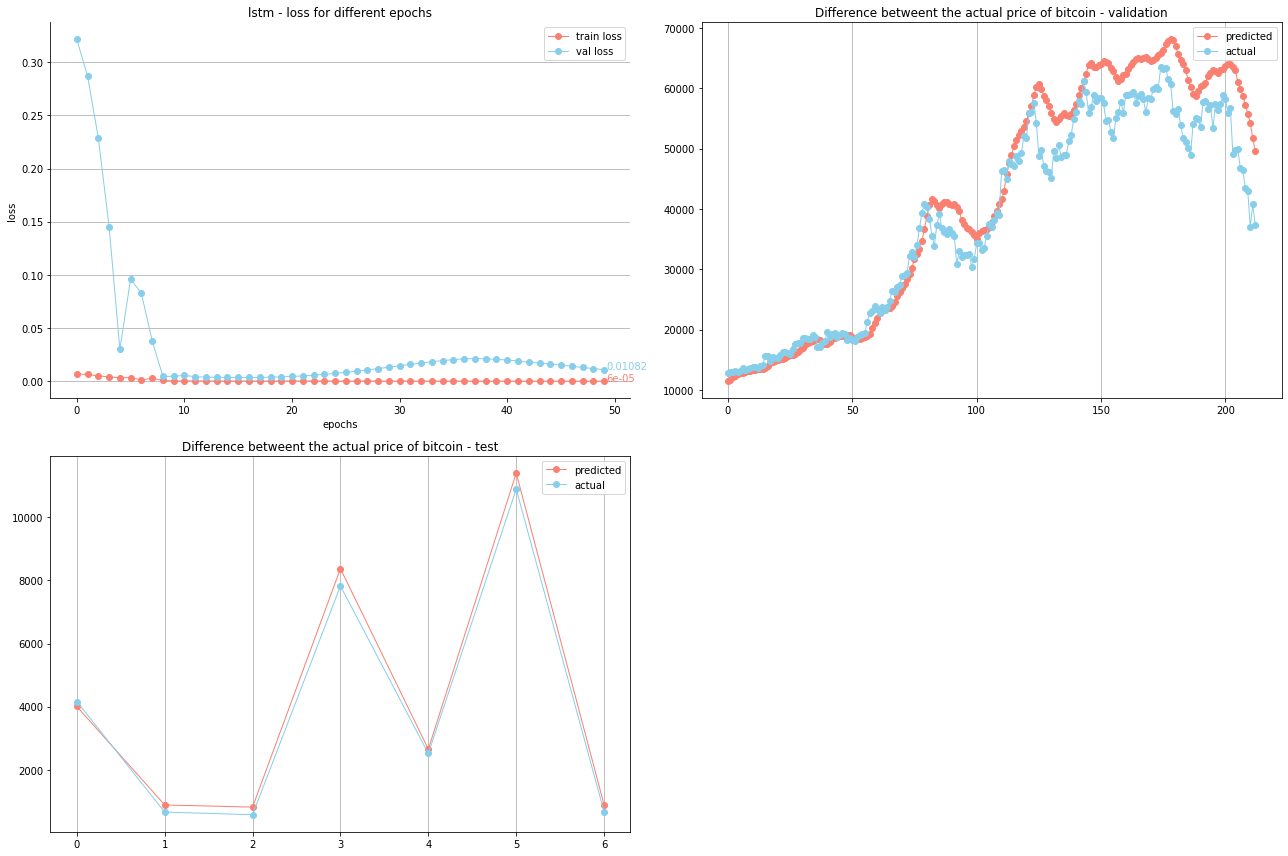

In [43]:
loss_fn = nn.MSELoss()
test_model(
    model_name='lstm', 
    epochs=epochs, 
    hidden_dim=hidden_dim,
    optimizer_name='adam',
    dropout_rate=None
)

Start training...

Training complete!
time elapsed: 27.686699867248535
the best loss on validation data: 0.008777395298238844
loss on the test data before the inversion of the transforms applied: 7.834009920770768e-06
actual rmse loss after inversion of the transforms applied: 177.24320849172284
actual mae loss after inversion of the transforms applied: 162.0226467415026


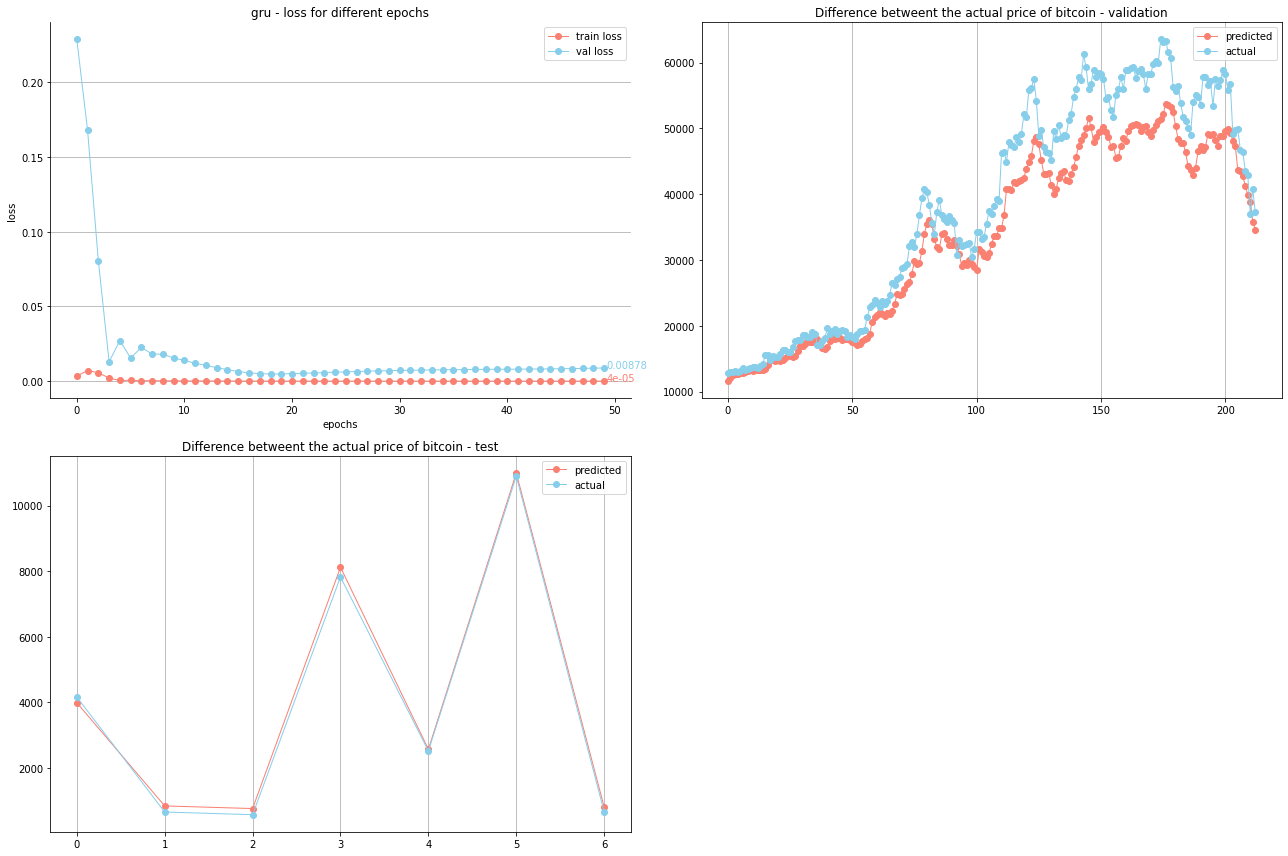

In [44]:
loss_fn = nn.MSELoss()
test_model(
    model_name='gru',
    epochs=epochs, 
    hidden_dim=hidden_dim, 
    optimizer_name='adam', 
    dropout_rate=None
)

Start training...

Training complete!
time elapsed: 11.537065267562866
the best loss on validation data: 0.025433377886656672
loss on the test data before the inversion of the transforms applied: 3.609055420383811e-05
actual rmse loss after inversion of the transforms applied: 380.42971954581776
actual mae loss after inversion of the transforms applied: 348.5202088739892


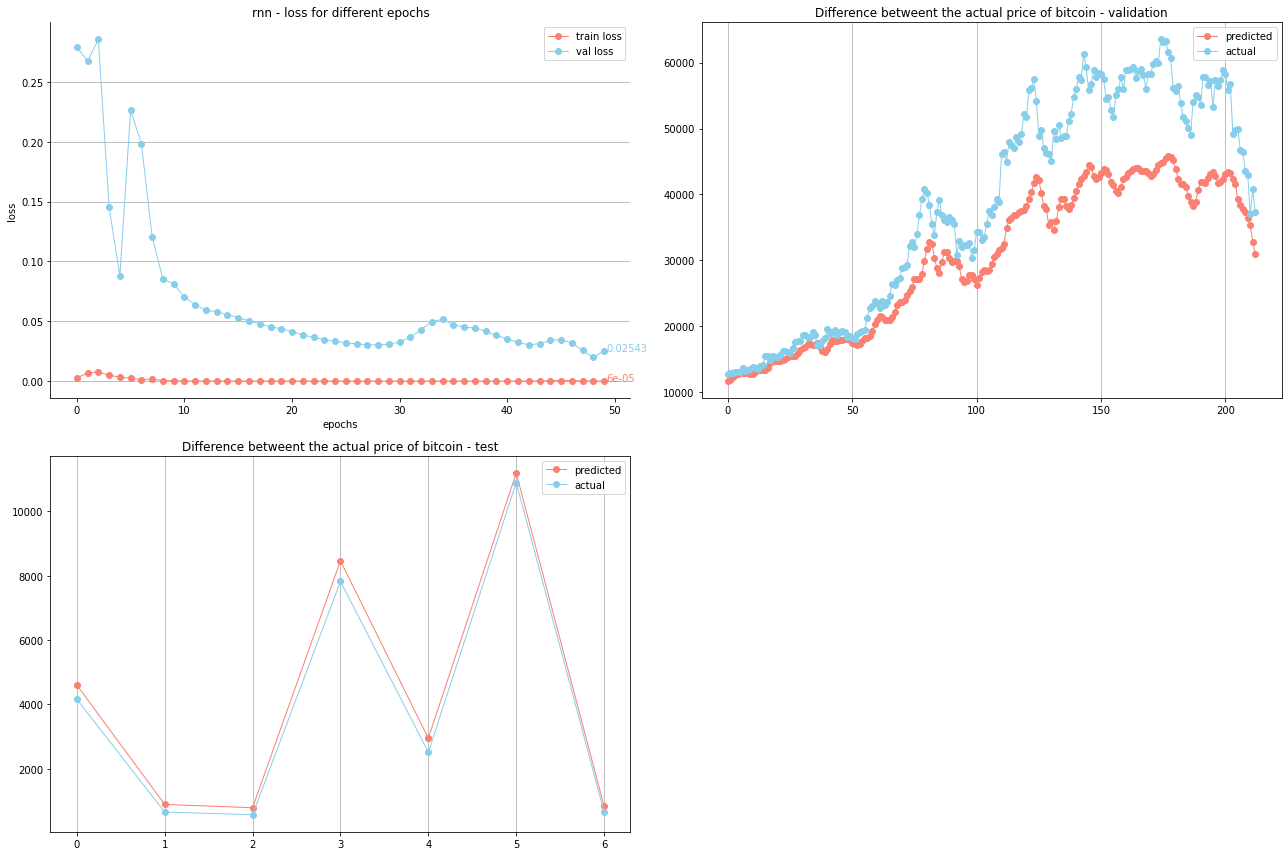

In [45]:
loss_fn = nn.MSELoss()
test_model(
    model_name='rnn', 
    epochs=epochs,
    hidden_dim=hidden_dim,
    optimizer_name='adam', 
    dropout_rate=None
)

As you can observe from the accuracy and the loss of the different models and their performance, the `GRU` model performs slightly better. The results are most likely because of the complexity of the model. As the LSTM model is designed to capture long dependencies and also complex patterns, it tend to overfit on this relatively easy task. However, GRU takes the lead and generalize better on the test data. RNN, too, can be a good model as it is a simple model that can capture dependencies like the one in our case.

### Comparing different models based on their optimizing function

Start training...

Training complete!
time elapsed: 28.007489919662476
the best loss on validation data: 0.008777395298238844
loss on the test data before the inversion of the transforms applied: 7.834009920770768e-06
actual rmse loss after inversion of the transforms applied: 177.24320849172284
actual mae loss after inversion of the transforms applied: 162.0226467415026


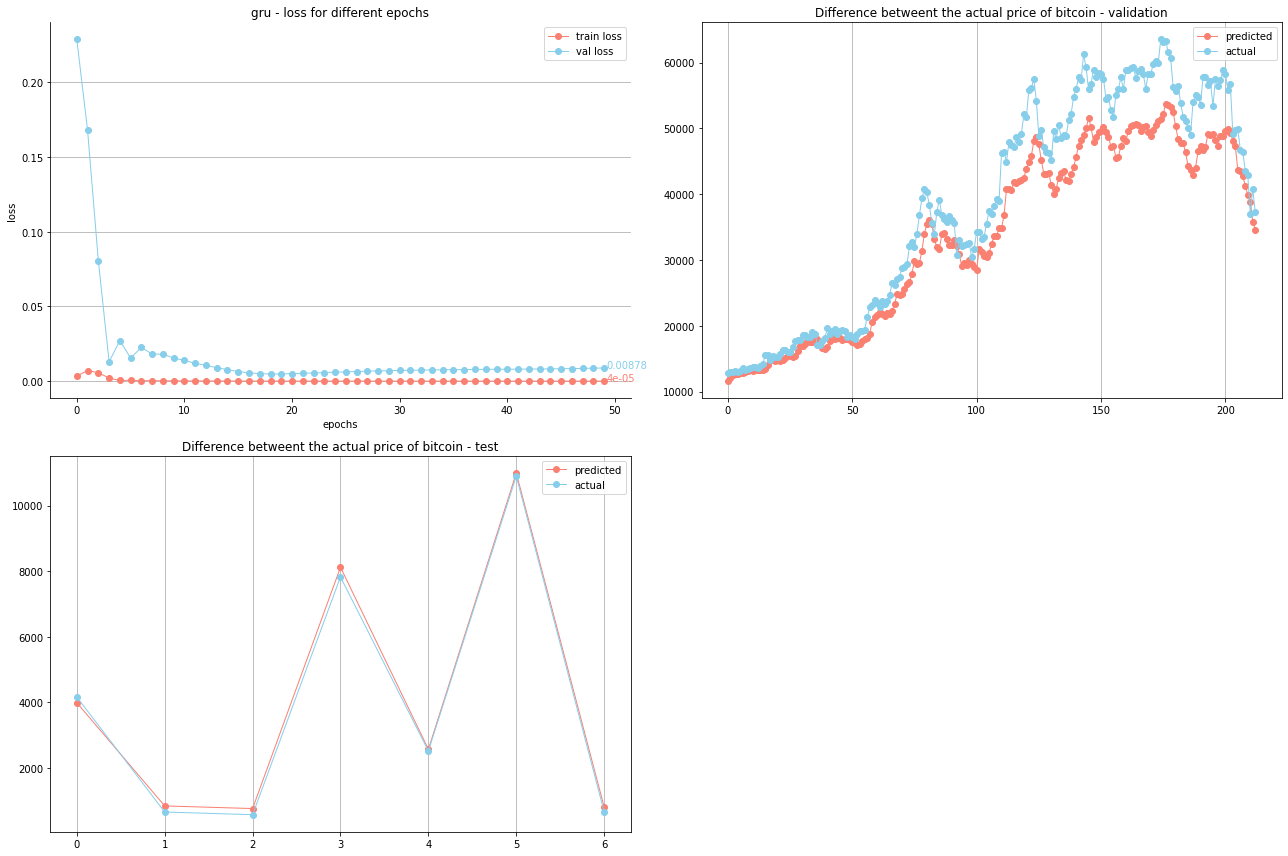

In [46]:
loss_fn = nn.MSELoss()
test_model(
    model_name='gru',
    epochs=epochs,
    hidden_dim=hidden_dim,
    optimizer_name='adam',
    dropout_rate=None
)

Start training...

Training complete!
time elapsed: 30.208635091781616
the best loss on validation data: 0.36147933918982744
loss on the test data before the inversion of the transforms applied: 0.003323869314044714
actual rmse loss after inversion of the transforms applied: 3650.8970225065054
actual mae loss after inversion of the transforms applied: 3272.4844585836313


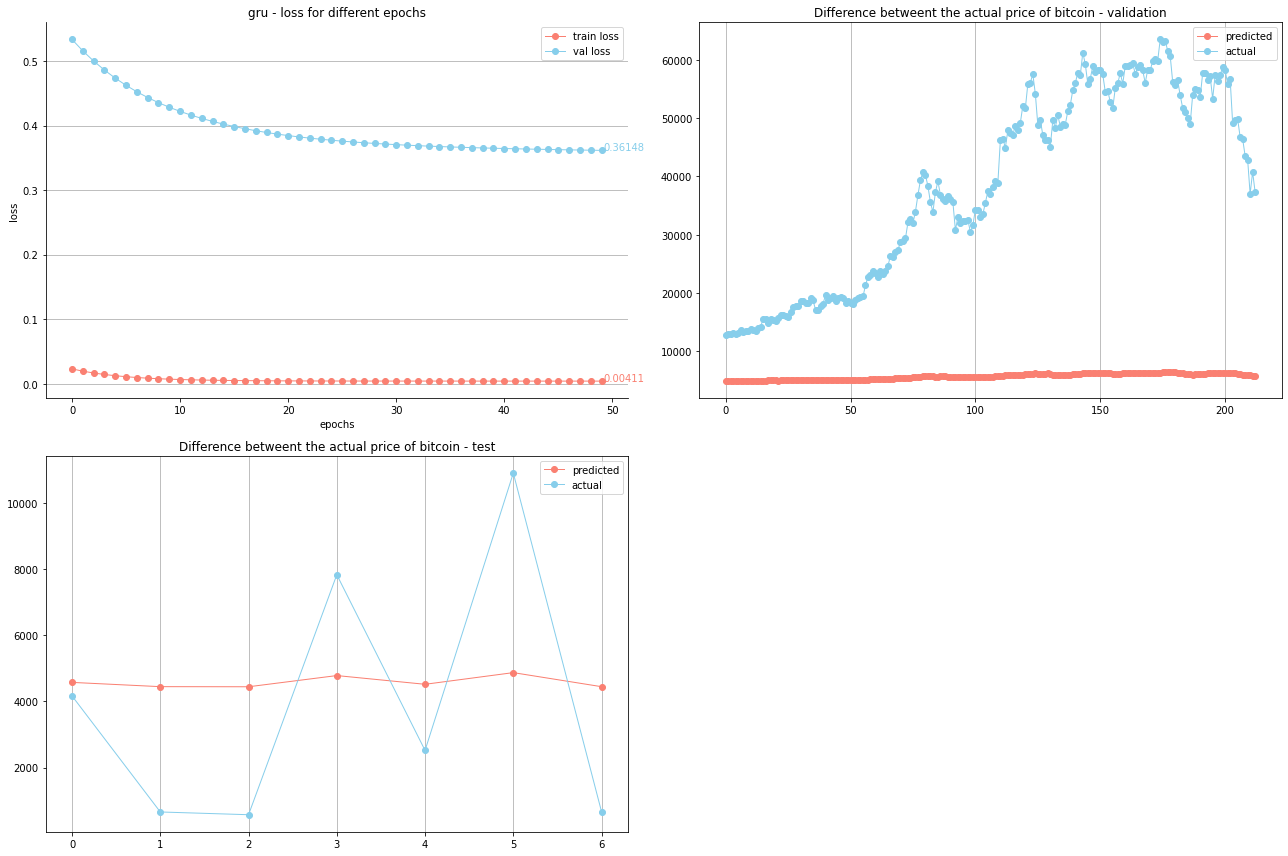

In [47]:
loss_fn = nn.MSELoss()
test_model(
    model_name='gru',
    epochs=epochs,
    hidden_dim=hidden_dim, 
    optimizer_name='sgd', 
    dropout_rate=None
)

Start training...

Training complete!
time elapsed: 27.74704885482788
the best loss on validation data: 0.001452214186429046
loss on the test data before the inversion of the transforms applied: 9.752992627909407e-05
actual rmse loss after inversion of the transforms applied: 625.3836936382645
actual mae loss after inversion of the transforms applied: 432.62970881947393


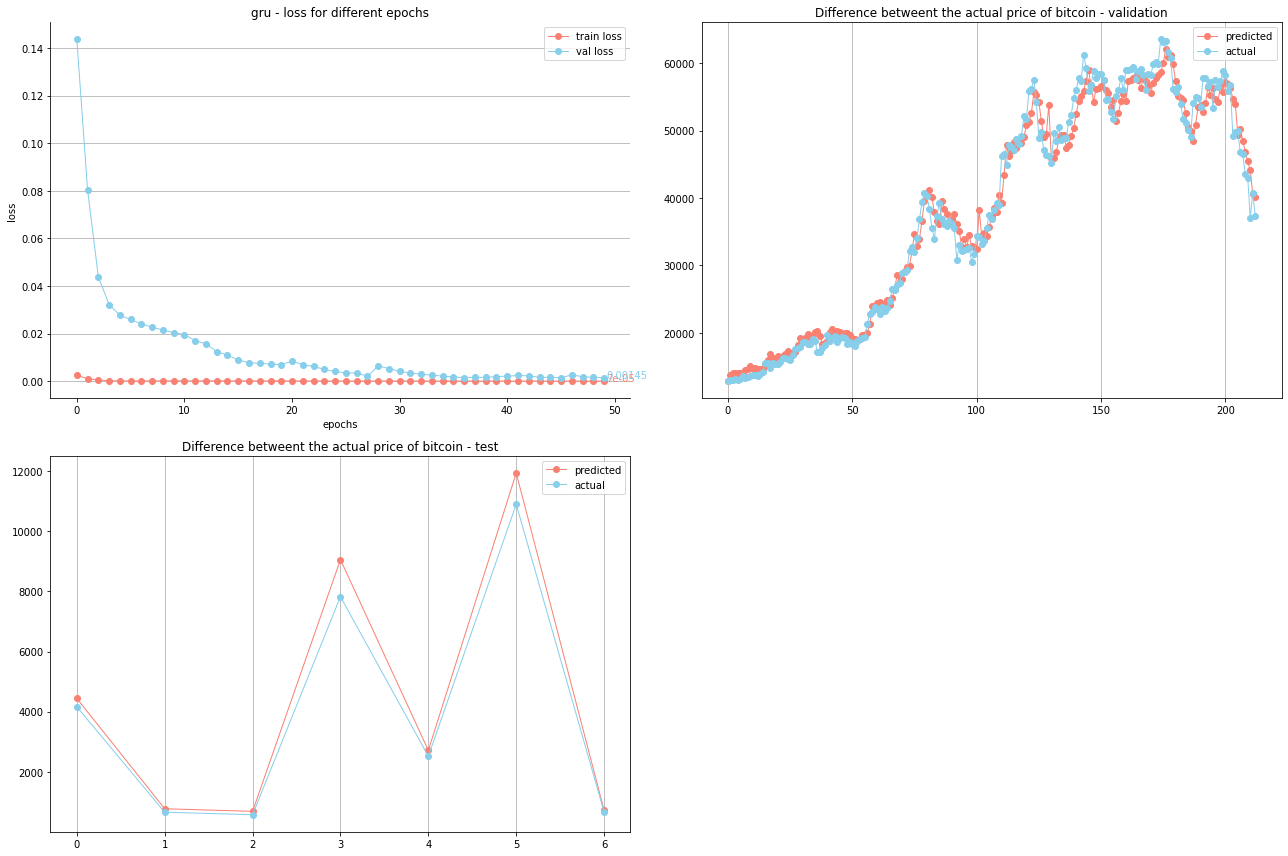

In [48]:
loss_fn = nn.MSELoss()
test_model(
    model_name='gru',
    epochs=epochs,
    hidden_dim=hidden_dim,
    optimizer_name='rmsprop',
    dropout_rate=None
)

Start training...

Training complete!
time elapsed: 27.170897960662842
the best loss on validation data: 0.015495102154091
loss on the test data before the inversion of the transforms applied: 3.3652340789558366e-05
actual rmse loss after inversion of the transforms applied: 367.3543308998509
actual mae loss after inversion of the transforms applied: 260.0799115107581


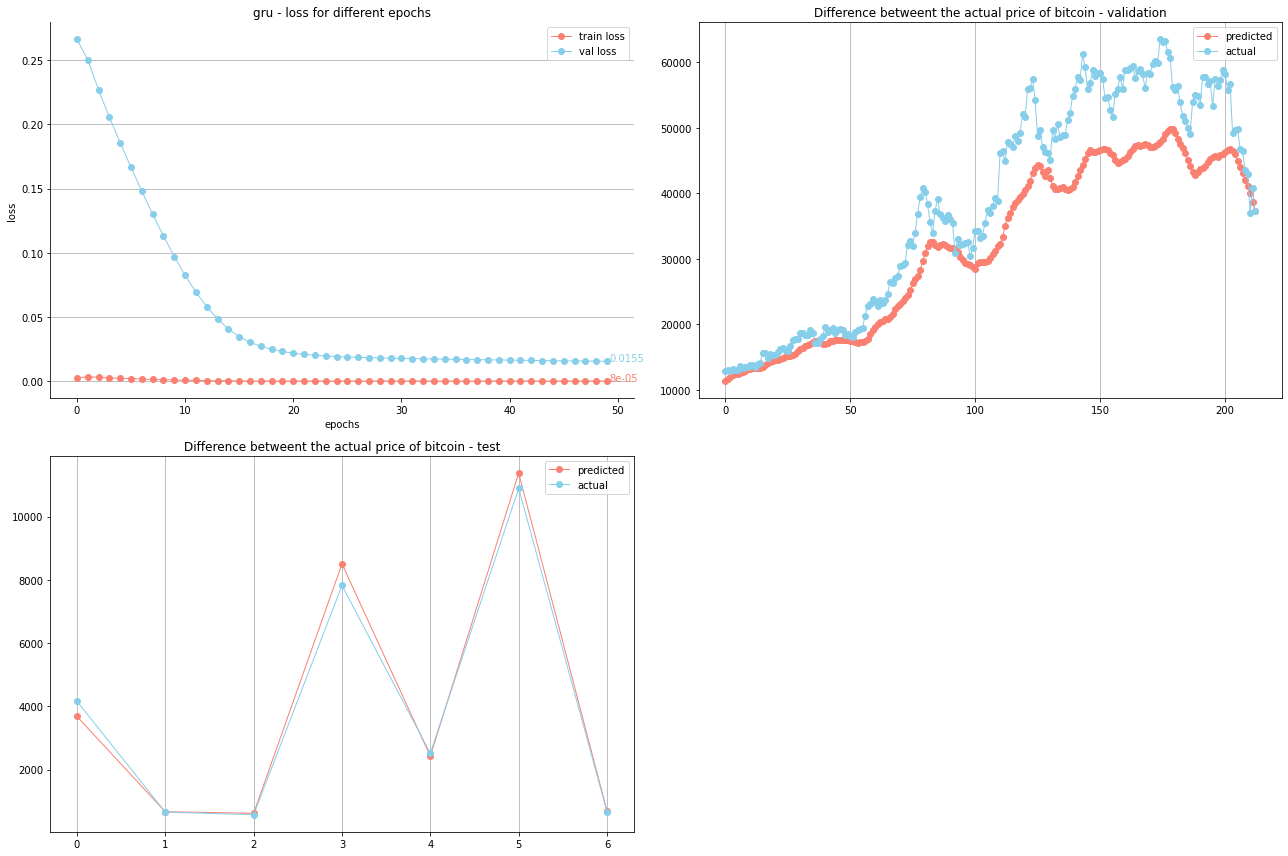

In [49]:
loss_fn = nn.MSELoss()
test_model(
    model_name='gru',
    epochs=epochs,
    hidden_dim=hidden_dim,
    optimizer_name='adagrad', 
    dropout_rate=None
)

As you can see the RMS prop performs better than SGD. The difference between Adam, RMSprop, and Adagrad cannot be so meaningful as they both come from the same family of optimizer functions.

### Comparing different loss functions

Start training...

Training complete!
time elapsed: 27.64931082725525
the best loss on validation data: 0.008777395298238844
loss on the test data before the inversion of the transforms applied: 7.834009920770768e-06
actual rmse loss after inversion of the transforms applied: 177.24320849172284
actual mae loss after inversion of the transforms applied: 162.0226467415026


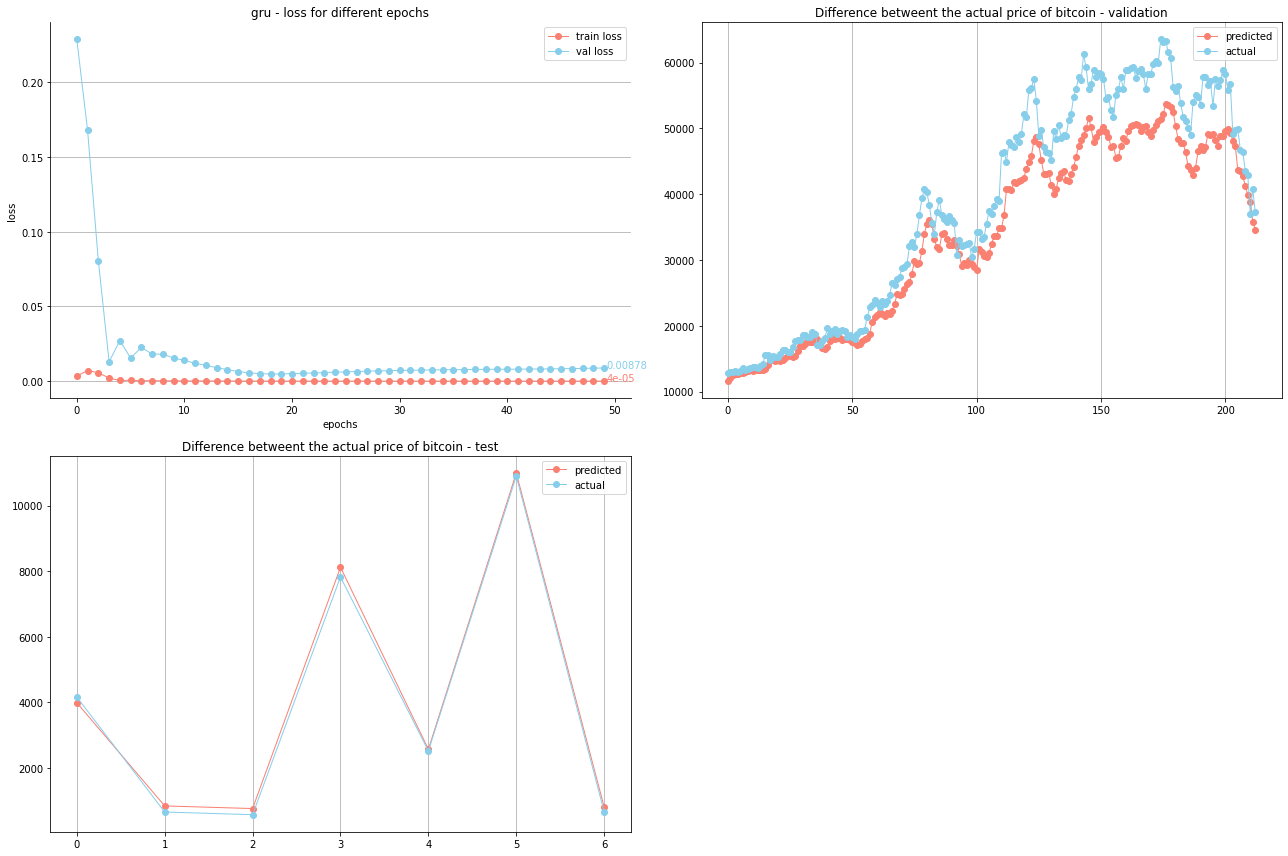

In [50]:
loss_fn = nn.MSELoss()
test_model(
    model_name='gru',
    epochs=epochs,
    hidden_dim=hidden_dim,
    optimizer_name='adam', 
    dropout_rate=None
)

Start training...

Training complete!
time elapsed: 27.925556182861328
the best loss on validation data: 0.02992058452218771
loss on the test data before the inversion of the transforms applied: 0.003990946803241968
actual rmse loss after inversion of the transforms applied: 266.0741009777284
actual mae loss after inversion of the transforms applied: 252.72804003053278


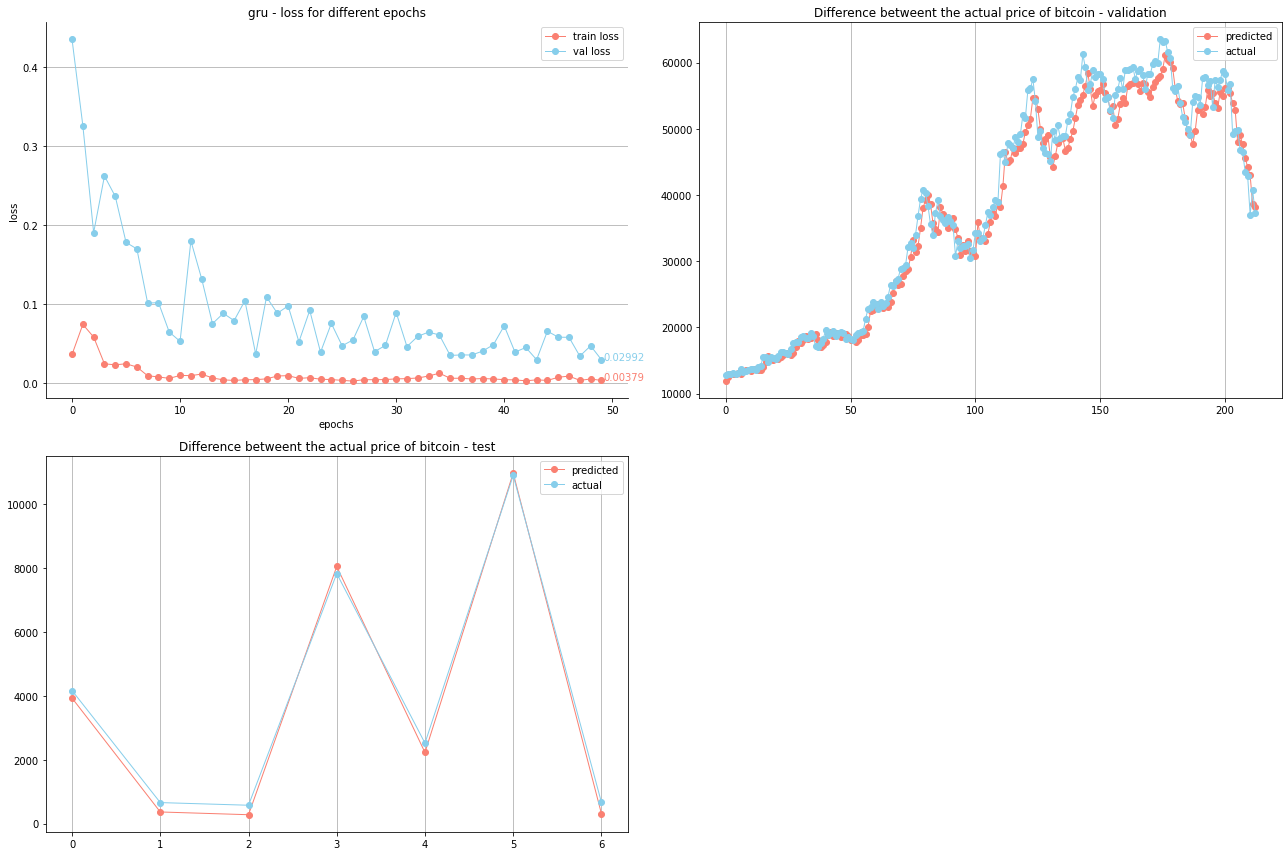

In [51]:
loss_fn = nn.L1Loss()
test_model(
    model_name='gru',
    epochs=epochs,
    hidden_dim=hidden_dim,
    optimizer_name='adam', 
    dropout_rate=None
)

MSE performs slightely better because of the fact that it penalizes the model for higher errors and in our case that the price can have different kinds of fluctuations, it helps us develop a better model.

### Examine the effect of Dropout layers on the performance of the model

Start training...

Training complete!
time elapsed: 100.96238803863525
the best loss on validation data: 0.004149442305788398
loss on the test data before the inversion of the transforms applied: 2.2840729798190296e-05
actual rmse loss after inversion of the transforms applied: 302.64436379826316
actual mae loss after inversion of the transforms applied: 262.73496139887067


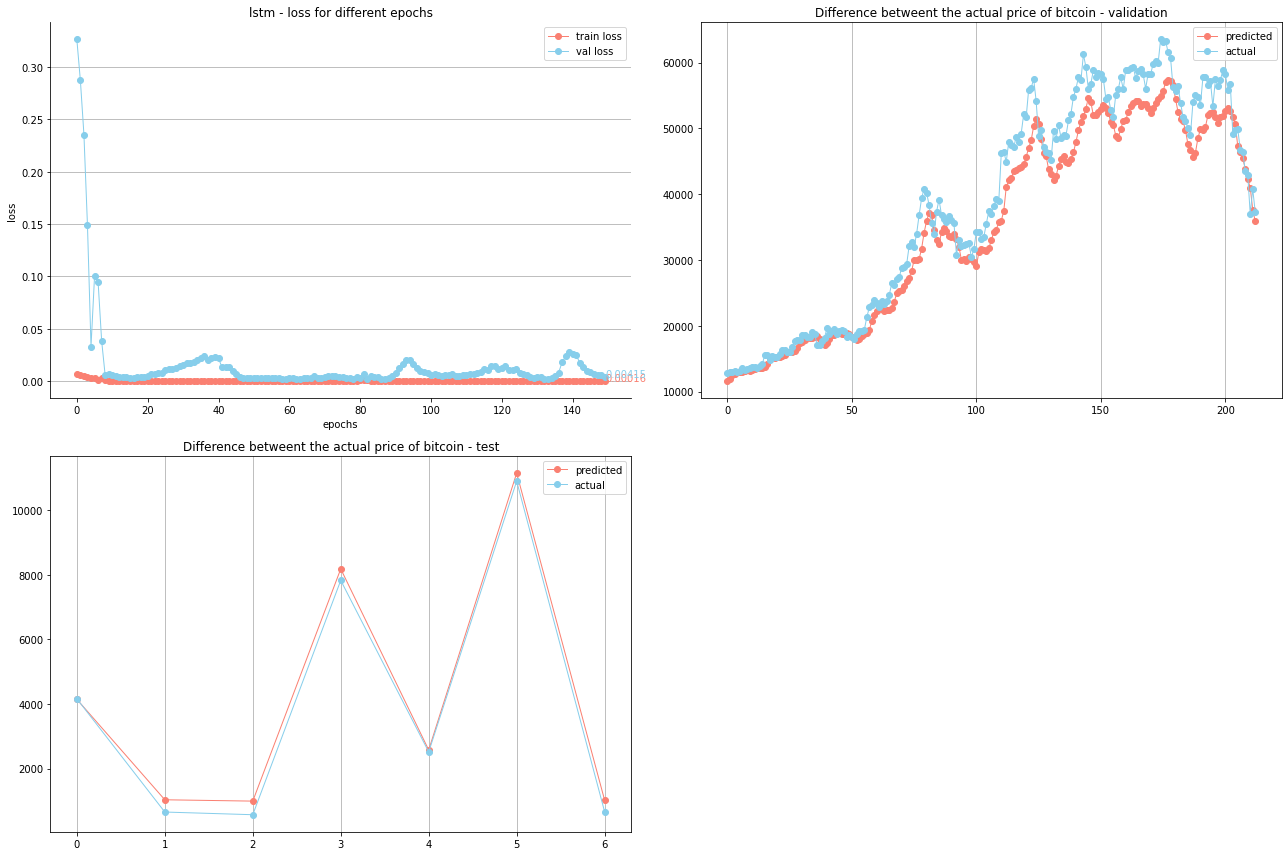

In [55]:
loss_fn = nn.MSELoss()
test_model(
    model_name='lstm',
    epochs=epochs*3,
    hidden_dim=hidden_dim,
    optimizer_name='adam', 
    dropout_rate=.05
)

Start training...

Training complete!
time elapsed: 88.89296293258667
the best loss on validation data: 0.005482095286424737
loss on the test data before the inversion of the transforms applied: 5.307777428242844e-06
actual rmse loss after inversion of the transforms applied: 145.89290934498425
actual mae loss after inversion of the transforms applied: 103.2662196916934


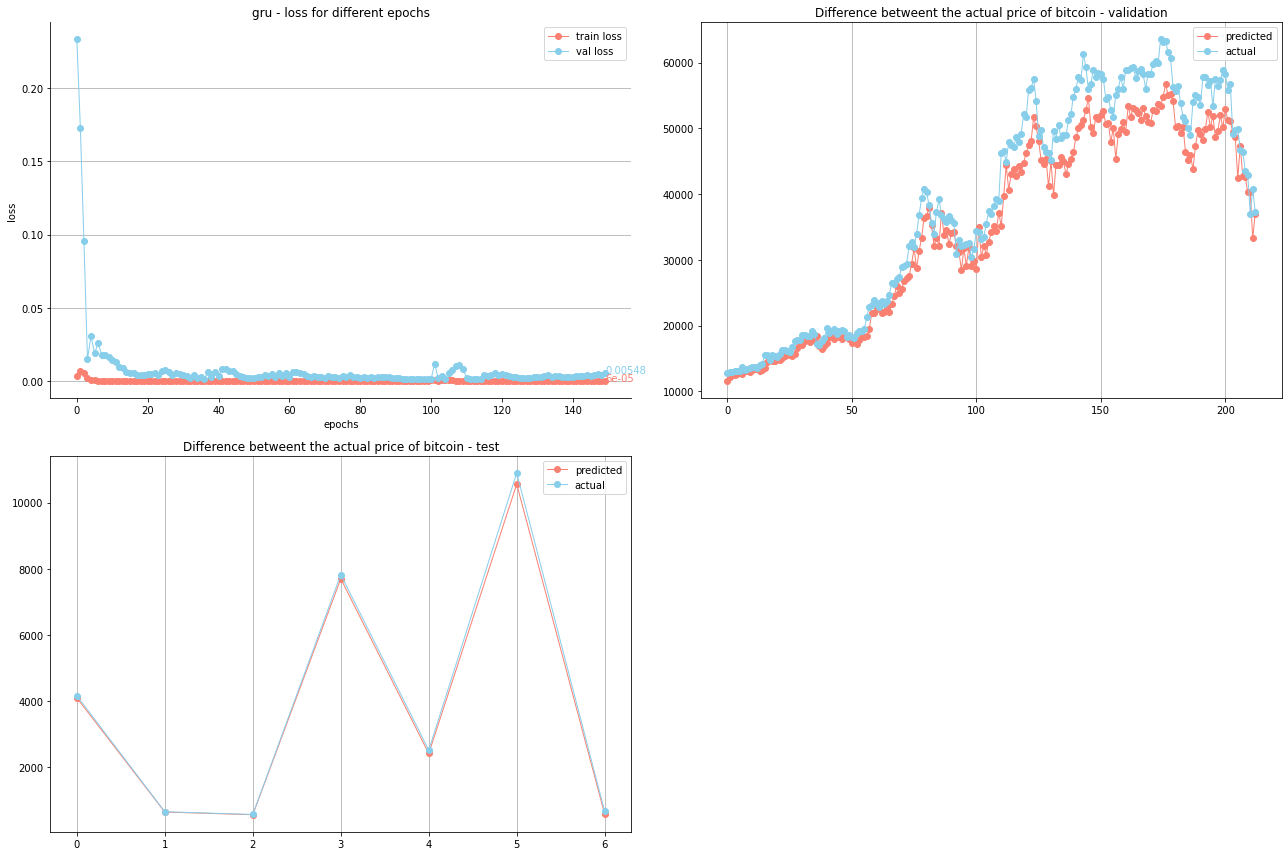

In [56]:
loss_fn = nn.MSELoss()
test_model(
    model_name='gru',
    epochs=epochs*3,
    hidden_dim=hidden_dim,
    optimizer_name='adam', 
    dropout_rate=.05
)

Start training...

Training complete!
time elapsed: 36.31348729133606
the best loss on validation data: 0.0022626788922934793
loss on the test data before the inversion of the transforms applied: 6.933753320481628e-05
actual rmse loss after inversion of the transforms applied: 527.3049792712322
actual mae loss after inversion of the transforms applied: 459.27701415251965


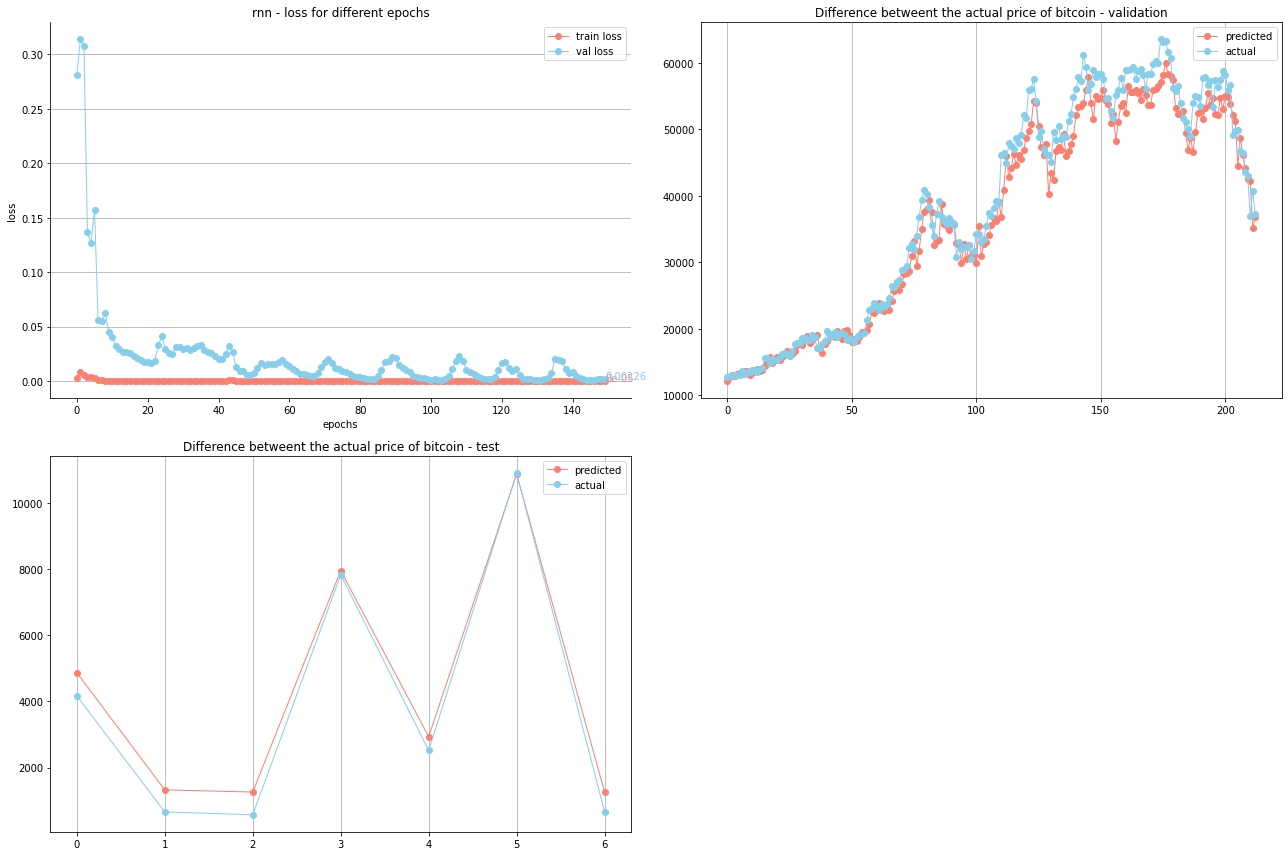

In [57]:
loss_fn = nn.MSELoss()
test_model(
    model_name='rnn',
    epochs=epochs*3,
    hidden_dim=hidden_dim,
    optimizer_name='adam', 
    dropout_rate=.05
)

As you can see from the performance of the model with and without the dropout layer, as the model and its layers are not extensively deep, adding the dropout layer would just cause the model to loose its learning ability. Considering the stochastic effect of dropout layer and that we have to look at the overall performance from multiple runs, we concluded that the dropout layer can be helpful but not that much.

### Develop a simple MLP model to compare the performance of this simple model with previous ones

In [58]:
class MLP_model(nn.Module):
    
    def __init__(self, n_features, hidden_dim, n_output, dropout_rate):
        super(MLP_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.n_features = n_features
        
        
        
        self.fc1 = nn.Linear(period*n_features, hidden_dim[0])
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.fc3 = nn.Linear(hidden_dim[1], hidden_dim[2])
        self.fc4 = nn.Linear(hidden_dim[2], hidden_dim[3])
        self.fc5 = nn.Linear(hidden_dim[3], n_output)
        
        if dropout_rate != None:
            self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        x = x.reshape((x.shape[0], -1))
        
        x = self.fc1(x)
        x = nn.ReLU()(x)
        if self.dropout_rate != None:
            x = self.dropout(x)
            
            
        x = self.fc2(x)
        x = nn.ReLU()(x)
        if self.dropout_rate != None:
            x = self.dropout(x)
            
            
        x = self.fc3(x)
        x = nn.ReLU()(x)
        
        x = self.fc4(x)
        x = nn.ReLU()(x)
        
        x = self.fc5(x)
        x = torch.squeeze(x, 1)
        return x

In [59]:
mlp_model = MLP_model(
    n_features=4, 
    hidden_dim=[256, 100, 100, 32], 
    n_output=1,
    dropout_rate=None
)
_ = mlp_model(torch.rand((batch_size, period, 4)))

Start training...

Training complete!
time elapsed: 6.018136024475098
the best loss on validation data: 0.04939579265192151
loss on the test data before the inversion of the transforms applied: 7.189874304458499e-05
actual rmse loss after inversion of the transforms applied: 536.9554989675328
actual mae loss after inversion of the transforms applied: 379.5661803580816


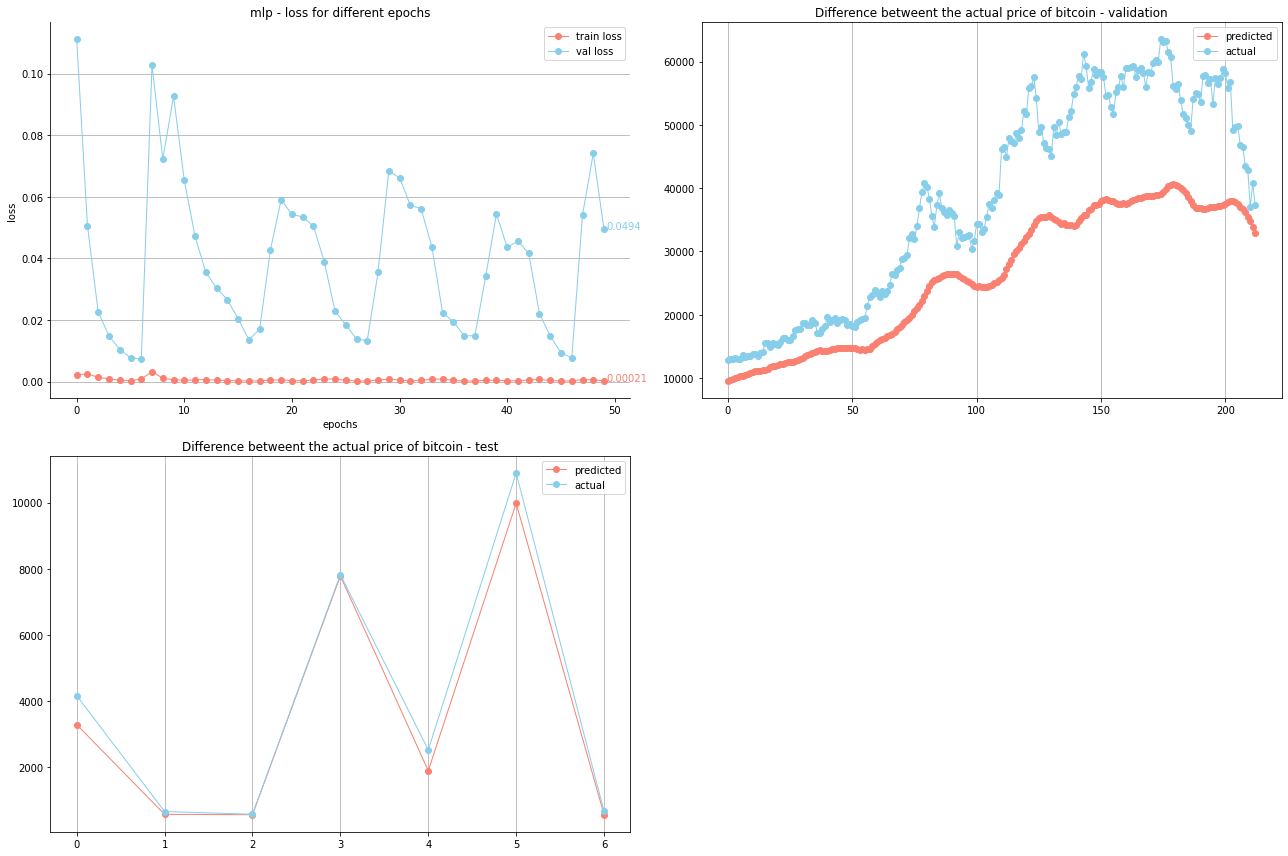

In [60]:
loss_fn = nn.MSELoss()
test_model(
    model_name='mlp',
    epochs=epochs,
    hidden_dim=[256, 100, 100, 32],
    optimizer_name='adam', 
    dropout_rate=None
)

### Examining the effect of more recurrent layers on the performance of the model

In [61]:
class Gru_extended_layers_model(nn.Module):
    
    def __init__(self, n_features, hidden_dim, n_output, dropout_rate):
        super(Gru_extended_layers_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.gru = nn.GRU(input_size=n_features, hidden_size=hidden_dim[0], batch_first=True, dropout=dropout_rate, num_layers=2)
        self.fc1 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.fc2 = nn.Linear(hidden_dim[1], n_output)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc1(x[:, -1, :])
        x = nn.ReLU()(x)
        x = torch.squeeze(self.fc2(x), 1)
        return x

Start training...

Training complete!
time elapsed: 126.03331398963928
the best loss on validation data: 0.03304984958958812
loss on the test data before the inversion of the transforms applied: 8.322259964188561e-05
actual rmse loss after inversion of the transforms applied: 577.6945648807915
actual mae loss after inversion of the transforms applied: 570.0264813568137


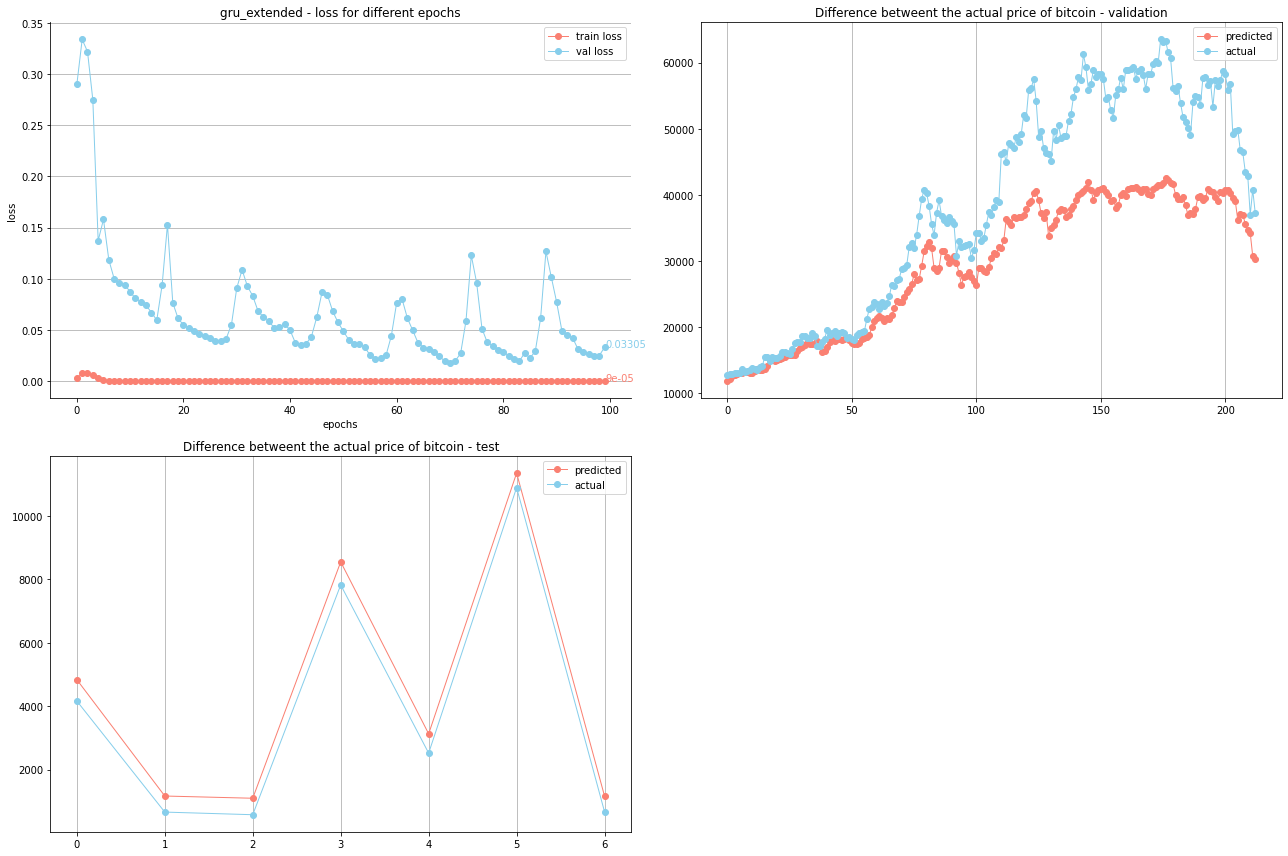

In [62]:
loss_fn = nn.MSELoss()
test_model(
    model_name='gru_extended',
    epochs=epochs*2,
    hidden_dim=hidden_dim,
    optimizer_name='adam', 
    dropout_rate=0.5
)

The effect of more recurrent layers can help us delve deeper into the more abstract structures embedded in the data ,of course, with more data and more training time as the complexity of the model require these to be able to learn.

### Implementation of CNN-LSTM architecture 

In [63]:
class CNN_LSTM_model(nn.Module):
    
    def __init__(self, n_features, hidden_dim, n_output, dropout_rate):
        super(CNN_LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=n_features, kernel_size=3, padding=1, stride=1)
        self.pooling = nn.AvgPool1d(kernel_size=3, padding=1, stride=1)
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_dim[0], batch_first=True)
        self.fc1 = nn.Linear(hidden_dim[0], hidden_dim[1])
        if dropout_rate != None:
            self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim[1], n_output)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        x = self.conv1(x)
        x = self.pooling(x)
        x = torch.transpose(x, 1, 2)
        x, _ = self.lstm(x)
        x = self.fc1(x[:, -1, :])
        x = nn.ReLU()(x)
        if self.dropout_rate != None: 
            x = self.dropout(x)
        x = torch.squeeze(self.fc2(x), 1)
        return x

Start training...

Training complete!
time elapsed: 32.73451495170593
the best loss on validation data: 0.08146394329378381
loss on the test data before the inversion of the transforms applied: 2.7642425266094506e-05
actual rmse loss after inversion of the transforms applied: 332.93971392856787
actual mae loss after inversion of the transforms applied: 270.522572627865


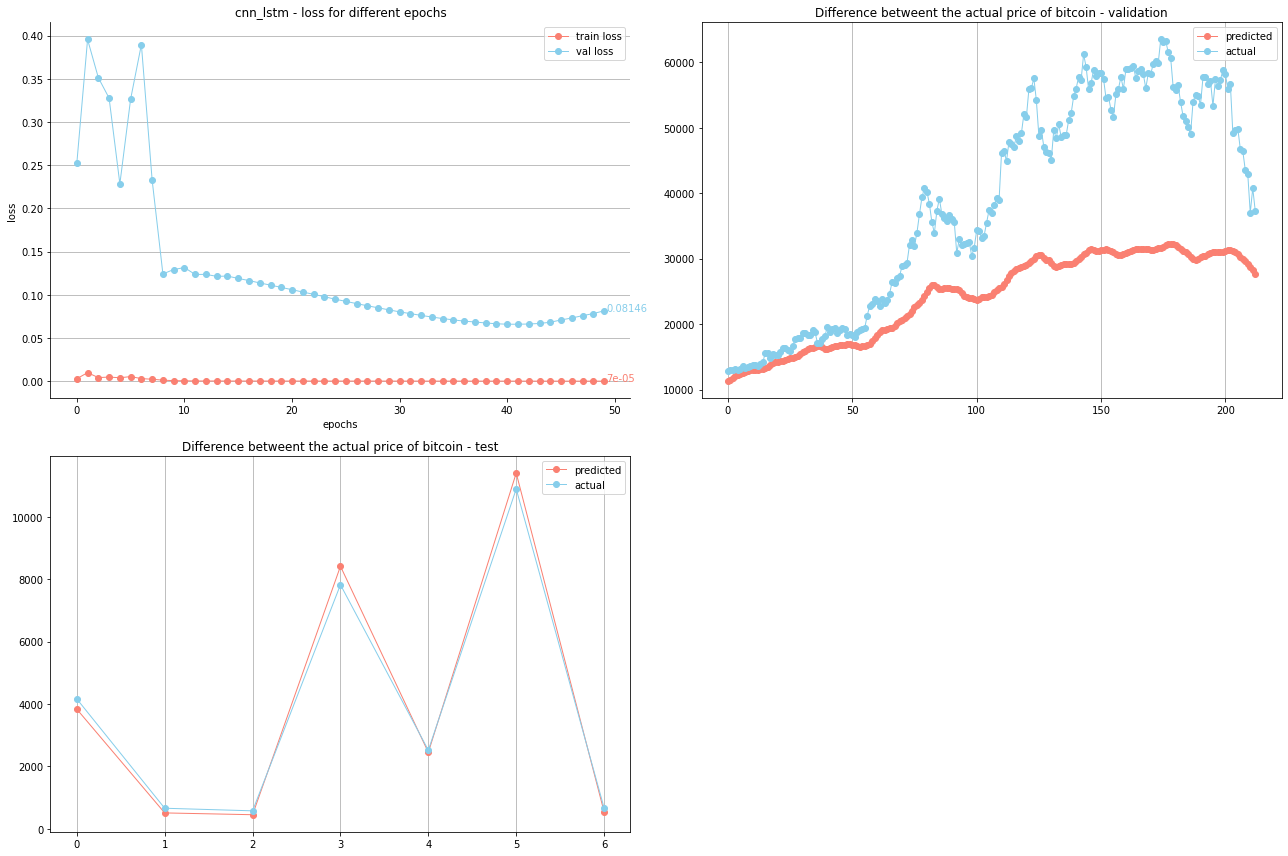

In [64]:
loss_fn = nn.MSELoss()
test_model(
    model_name='cnn_lstm',
    epochs=epochs,
    hidden_dim=hidden_dim,
    optimizer_name='adam', 
    dropout_rate=None
)